# Baseball Elimination Lab

**Objectives:**
* Introduce students to a sophisticated formulation using the
maximum flow problem.
* Demonstrate how to solve the application by the
Ford-Fulkerson algorithm.

**Key Ideas:**
* integrality property
* max-flow min-cut theorem
* the baseball elimination problem

**Reading Assignment:**
* Read Handout 6 on the baseball elimination problem.

**Brief description:** In this lab, we will learn how to formulate the so-called baseball elimination problem as a maximum flow problem and use the output of the Ford-Fulkerson algorithm to determine whether a team can still win the division, and if not, why. We will again use the Python package NetworkX.

<font color='red'>**Instructor Comments**</font>

<font color='blue'>**Solutions**</font>

## Part 1: Baseball Elimination Max-Flow Formulation


You have seen an example for the Baseball Elimination Problem in
class. Recall that the data for this problem consists of the following:
* a collection of teams $1, 2, \ldots, n$,
* the number of games $g(i,j)$ remaining to be played between teams $i$ and $j$ for all pairs of teams $i$ and $j$,
* the number of wins $w(i)$ team $i$ already has.

We would like to determine if team $n$ (our favorite) has
been eliminated already: that is, even if team $n$ wins all
of its remaining games, no matter how the games between the other
teams turn out, there will always be some team with more wins than
team $n$ at the end of the season.  If it is possible for
team $n$ to finish the season at least tied for first, then
it has not been eliminated.

Consider the following data for a 4 team league:

Team | Wins 
--- | ---
1 | 8 
2 | 10
3 | 10
4 | 1

Games remaining to be played:

vs. | 1 | 2 | 3 | 4
 -- | -- | -- | -- | --
**1** | - | 3 | 3 | 6
**2** | 3 | - | 6 | 3
**3** | 3 | 6 | - | 3
**4** | 6 | 3 | 3 | -


Our team (team 4) didn't do very well so far. We would like
to determine whether it still has a chance to finish first at the end
of the season (we are satisfied with a tie for first place as
well). 

**Q1:** How many games can team 4 possibly win during the
season? Call this number $W$. (Hint: assume that team 4 wins all their remaning games.)

In [1]:
W = 13

Team 4 finishes first if no other team wins more games than $W$.  

**Q2:** What if (hypothetically) team 1 already had 14 wins? Can our team come out first?

**A:** <font color='blue'>No, team 4 could have at most 1 + 12 = 13 wins by the end of the season and team 1 already has 14</font>

Team 1 has already won 8 games.  

**Q3:** At most how many more games is this team allowed to win if we want to make sure that our team comes out first? What about teams 2 and 3?

**A:**  <font color='blue'> An upper bound on the number of games team 1 could win is 13 - 8 = 5. Teams 2 and 3 could win at most 3 more games.</font>

**Q4:** How can you express this amount in general (in terms of $W$ and $w(i)$)
for team $i$?

**A:** <font color='blue'> $W - w(i)$</font>

If one of two teams scheduled to play is team 4, then we assume
that the game outcome is decided in our favor. For the rest of the games, we
would like to assign a winner so that no team wins more games than the
number determined above. So for each pair of teams (other than those
containing our team) we would like to decide how many of the leftover
games between them are going to be won by one team or the other.


To illustrate this, we draw two sets of nodes: one set for all the
pairs of teams not containing our team (these will be called the 
*pair nodes*) and another one for the individual teams (these are
called the *team nodes*). We can interpret $g(i,j)$, the number of 
games remaining to be played between teams $i$ and $j$, as the amount
of "excess games" at the pair node. These games need to be "distributed" 
between the two corresponding team nodes as represented by edges.  

**Q5:** Complete the following code and run the cell to add edges to our graph.


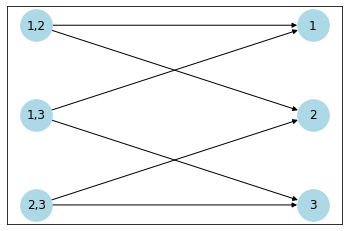

In [2]:
import networkx as nx

G = nx.DiGraph()
# pair nodes
G.add_node('1,2', pos=(10,30))
G.add_node('1,3', pos=(10,20))
G.add_node('2,3', pos=(10,10))
# team nodes
G.add_node('1', pos=(20,30))
G.add_node('2', pos=(20,20))
G.add_node('3', pos=(20,10))

# FILL IN THE EDGES --remember that they are directed edges, so the order of endpoints matter
G.add_edge('1,2', '1')
G.add_edge('1,2', '2')
G.add_edge('1,3', '1')
G.add_edge('1,3', '3')
G.add_edge('2,3', '2')
G.add_edge('2,3', '3')

# graph display
pos=nx.get_node_attributes(G,'pos')
nx.draw_networkx(G,pos,node_size=1000,node_color='lightblue')

To make a single-source, single-sink flow problem from
this model, we introduce two nodes: a node which is the "source
of all games" and a node which is the "sink of all played
games".  

**Q6:** What should be the capacity of (source, pair node) arcs? What about (team node, sink) arcs? Fill in the capacity values missing in the code below and run the cell to display the graph.

<font color='blue'>* We make the capacity of $(s,(i,j))$ edges equal to the number of games left to play $g(i,j)$ and the capacity of $(i,t)$ edges equal to the maxium number of games team $i$ can win $W - w(i)$</font>

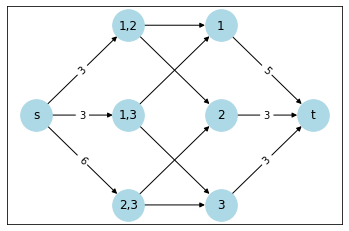

In [3]:
# adding our source node and sink node
G.add_node('s', pos=(0,20))
G.add_node('t', pos=(30,20))

# FILL IN THE CAPACITIES
G.add_edge('s', '1,2', capacity = 3)
G.add_edge('s', '1,3', capacity = 3)
G.add_edge('s', '2,3', capacity = 6)
G.add_edge('1', 't', capacity = 5)
G.add_edge('2', 't', capacity = 3)
G.add_edge('3', 't', capacity = 3)

# graph display
pos=nx.get_node_attributes(G,'pos')
cap=nx.get_edge_attributes(G,'capacity')
nx.draw_networkx(G,pos,node_size=1000,node_color='lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=cap);

**Q7:** In class, we used capacities
of $\infty$ on the (pair node, team node) arcs.  Why is this
appropriate?

**A:** <font color='blue'> The flow on (pair node, team node) edges can only be as great as the number of games left for pair (i,j) to play. Either team can win any number of the remaining games so it is appropriate to assign capacities of $\infty$ to these edges</font>

**Q8:** What does a feasible flow, with all integer flow values,
in the above network correspond to? How can we interpret the value
of a flow? 

**A:** <font color='blue'>We can interpret the flow on $(s,(i,j))$ to be the number of new games played between teams $i$ and $j$, $((i,j), i)$ arcs to be the number of games team $i$ won aganist team $j$, and $(i,t)$ arcs to be the total number of addtional wins team $i$ has. </font>

**Q9:** How can we tell whether our team is eliminated by solving the maximum
flow problem on the above network? What has to be the value of the
maximum flow if our team is not eliminated?

**A:** <font color='blue'>The max flow must be equal to the total number of games remaining between all teams $(i,j)$ where $i \neq 4$ and $j \neq 4$. This corresponds to an outcome in which all the remaining games are played and no other team gets strictly more wins than team 4.</font>

**Q10:** Solve the maximum flow problem on the above network with
the Ford-Fulkerson algorithm. What is the value of the maximum
flow? What is the maximum flow (i.e. the actual flows on the
arcs)? What about the minimum cut (i.e., which nodes are on the $s$ side, which on the $t$)?

**A:** <font color='blue'>The max flow is 11 where $$f(2,(1,2)) = 3, f((1,2),1) = 3, f(s,(1,3)) = 2, f((1,3),1) = 2, f(s,(2,3)) = 6, f((2,3),2) = 3, f((2,3),3) = 3,$$ $$f(1,t) = 5, f(2,t) = 3, f(3,t) = 3$$. The minimum cut is $S = N \setminus \{t\}$. </font>  

Check your answer by running the following cell, which will compute a maximum flow in the graph $G$ we defined previously.

In [4]:
flow_value, flow = nx.maximum_flow(G, 's', 't')
print("The value of the flow is", flow_value)
for i, j in G.edges:
    print("The flow on the arc from "+i+" to "+j+" is",flow[i][j])

The value of the flow is 11
The flow on the arc from 1,2 to 1 is 3
The flow on the arc from 1,2 to 2 is 0
The flow on the arc from 1,3 to 1 is 2
The flow on the arc from 1,3 to 3 is 0
The flow on the arc from 2,3 to 2 is 3
The flow on the arc from 2,3 to 3 is 3
The flow on the arc from 1 to t is 5
The flow on the arc from 2 to t is 3
The flow on the arc from 3 to t is 3
The flow on the arc from s to 1,2 is 3
The flow on the arc from s to 1,3 is 2
The flow on the arc from s to 2,3 is 6


**Q11:** Has our team been eliminated already or not yet? If it
hasn't been eliminated, give a short scenario (i.e. a way
for the remaining games to turn out) by which our team could end
the season at least tied for first place. If it has been
eliminated, give a short explanation why. (Imagine you are trying
to explain it to a friend who doesn't know anything about the max
flow or min cut problems.)

**A:** <font color='blue'>Our team has been eliminated. We can only play 11 of the remaining 12 games before another team must have more wins than team 4. </font>

**Q12a:** If team 4 was not eliminated, then how many games from the
rest of the season could it lose and still come in first place?
Does it matter which of its remaining games it loses?

**A:** <font color='blue'>N/A </font>  

**Q12b:** If team 4 was eliminated, how many additional games should it
have won from the first part of the season in order to have prevented
this early end to its competitive season? Does it matter against which 
teams these additional win(s) come from?

**A:** <font color='blue'> Team 4 just needed one additional win. It does not matter who this win was aganist. </font>  

Now assume that team 3 had only 9 wins (the total
number of games is one less than previously).  

**Q13:** How is the network going to change? Will team 4 be eliminated in this case? Also answer Q11 and Q12a/b for this case.

**A:** <font color='blue'> The edge $(3,t)$ now has capacity 4. There is now a max flow with value 12. Hence, team 4 will not be eliminated. They must win all of their remaining games. </font>  

**Q14:** Going back to the general formulation of the Baseball
Elimination Problem given at the beginning of this lab, how many
pair nodes and how many team nodes are we going to have if the
number of teams is $n$?

**A:** <font color='blue'> We will have $n-1$ team nodes and $(n-1)^2 - (n-1)$ pair nodes </font>  

**Q15:** Write down in terms of the general formulation what the
nodes, arcs and arc capacities correspond to.

**A:** <font color='blue'>We have a source $s$ and sink $t$. Furthermore, we have a pair node $(i,j)$ for every pair of teams $(i,j)$ where $i \neq n$ and $j \neq n$ and team node $i$ for all teams $i \neq n$. We have arcs $(s,(i,j))$ with capacity equal to the number of games left to play between teams $i$ and $j$, arcs $((i,j),i)$ and $((i,j),j)$ with capacity $\infty$, and arcs $(i,t)$ with capacity $W - w(i)$ </font>  

## Part 2: Proof of Elimination

Here is the data from another season.

Team | Wins 
--- | ---
1 | 7
2 | 7
3 | 3
4 | 3

Games remaining to be played:

vs. | 1 | 2 | 3 | 4
 -- | -- | -- | -- | --
**1** | - | 3 | 1 | 1
**2** | 3 | - | 1 | 1
**3** | 1 | 1 | - | 3
**4** | 1 | 1 | 3 | -

**Q16:** Finish the code and run the cell to display the new graph. We once again are cheering for team 4.  

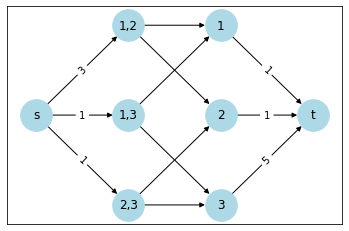

In [5]:
# creating a new graph
G = nx.DiGraph()
G.add_node('s', pos=(0,20))
G.add_node('t', pos=(30,20))
G.add_node('1,2', pos=(10,30))
G.add_node('1,3', pos=(10,20))
G.add_node('2,3', pos=(10,10))
G.add_node('1', pos=(20,30))
G.add_node('2', pos=(20,20))
G.add_node('3', pos=(20,10))

# FILL IN THE EDGES --remember that they are directed edges, so the order of endpoints matter
G.add_edge('1,2', '1')
G.add_edge('1,2', '2')
G.add_edge('1,3', '1')
G.add_edge('1,3', '3')
G.add_edge('2,3', '2')
G.add_edge('2,3', '3')

# FILL IN THE CAPACITIES
G.add_edge('s', '1,2', capacity = 3)
G.add_edge('s', '1,3', capacity = 1)
G.add_edge('s', '2,3', capacity = 1)
G.add_edge('1', 't', capacity = 1)
G.add_edge('2', 't', capacity = 1)
G.add_edge('3', 't', capacity = 5)

pos=nx.get_node_attributes(G,'pos')
cap=nx.get_edge_attributes(G,'capacity')
nx.draw_networkx(G,pos,node_size=1000,node_color='lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=cap);

**Q17:** Can you tell if team 4 is eliminated or not? If the team is not yet eliminated, give a short scenario where the team comes out first. If the team is eliminated, explain why this happened to your friend who doesn't know anything about Operations Research.

**A:** <font color='blue'> Team 4 is eliminated. Both teams 1 and 2 can only win one more game but they must play each other 3 more times. Hence, one of them will have two more wins. </font>  

**Q18:** Is it possible for a minimum $s$-$t$ cut in the general
network to have infinite capacity? Why?

**A:** <font color='blue'> No, consider the cut $S = N \setminus \{t\}$. The edges $(i,j)$ where $i \in S$ and $j \notin S$ will all be of the form $(i,t)$. All edges of this form have finite capacity. Thus, this cut always has finite capacity. Hence, there can not be a minimum cut with infinite capacity because this would imply no cut had finite capacity.</font>  

**Q19:** Consider the pair node $i,j$ and the team nodes $i$ and $j$. Is it possible for the pair node to be in the minimum cut but not the team nodes? Why? (Hint: use what you learned in Q18)

**A:** <font color='blue'> No, there are infinite capcity arcs from the pair node to each team node. In Q18 we argued why it is impossible for the minimum $s-t$ cut to have infinite capacity. Hence, all three of the pair node and two team nodes must be inside or outside the minmum cut. Otherwise, the minimum cut would have infinite capacity. </font>  

**Bonus:** Consider the edges of infinite capacity. Why is $\hat G + 1$ where $\hat G$ is the sum of all finite capacity edges sufficently large?

**A:** <font color='blue'> Note the property the infinte capacity edges give us: we know the min-cut must not include edges of infinite capacity because one of finite capacity always exists. Similarly, if the edge weight is $\hat G + 1$, this still holds true since there is always a cut that consists of some subset of the finite capacity edges and the weight of that cut will always be $\leq \hat G < \hat G + 1.$  </font>  

Let's look at the min-cut for this graph by running the labeling algorithm after running Ford-Fulkerson to find an optimal flow. The python package `max_flow` contains the functions you wrote in the max-flow lab with some additional visualizations.

In [6]:
from max_flow import *
ex = max_flow(add_infinite_capacities(G)) # create a max flow instance from the graph G
ex.ford_fulkerson(show=False) # run Ford-Fulkerson

**Q20:** Now that we have run Ford-Fulkerson, let's run the labeling algorithm. At each iteration, you will be asked to select the next node to explore from the set of unexplored nodes. Furthermore, the residual graph is plotted with the checked nodes colored red.

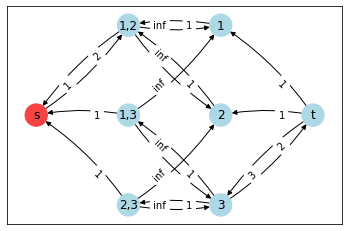

Unexplored nodes: {'s'}
Choose next node to explore: s
Looking at node 's'. Its neighbors are ['1,2'].
Node '1,2' now checked and prev set to 's'.


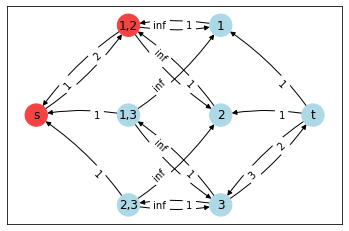

Unexplored nodes: {'1,2'}
Choose next node to explore: 1,2
Looking at node '1,2'. Its neighbors are ['s', '1', '2'].
Node 's' already checked.
Node '1' now checked and prev set to '1,2'.
Node '2' now checked and prev set to '1,2'.


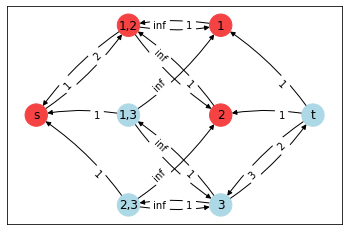

Unexplored nodes: {'2', '1'}
Choose next node to explore: 1
Looking at node '1'. Its neighbors are ['1,2'].
Node '1,2' already checked.


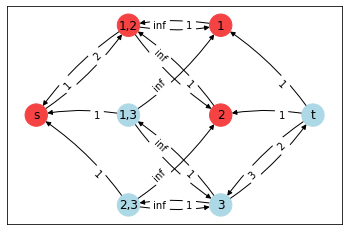

Unexplored nodes: {'2'}
Choose next node to explore: 2
Looking at node '2'. Its neighbors are ['1,2'].
Node '1,2' already checked.


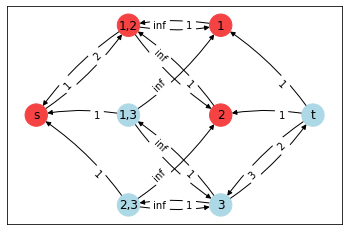

In [7]:
ex.label(auto=False,show=True)

**NOTE**: It is important to distinguish between the residual graph and the flow graph here. We run the labeling algorithm on the *residual* graph to find the set of reachable nodes. The residual graph for an optimal flow must not have an $s-t$ path which implies $t$ will not be reachable. Therefore, we can view the set of checked nodes as a cut on the graph (a min-cut more specifically.) When we look at the capacity of this cut, we go back to looking at the *flow* graph.

The following cell plots the flow graph with the final set of checked nodes. It may be helpful in answering the next question.

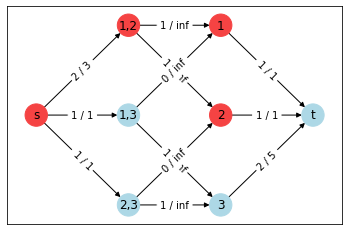

In [8]:
ex.plot_checked()

**Q21:** What min-cut does the labeling algorithm give us? What is it's capacity?

**A:** <font color='blue'> $S = \{s,(1,2),1,2\}$. It has capacity 4.</font>  

**Q22:** Are there any pair nodes in the cut? What do you notice about the capacity of the arc into the pair node in relation to the capacities coming out of the team nodes? How can this be interpretted in terms of the baseball eleimination problem?

**A:** <font color='blue'> The pair node $(1,2)$ is in the cut. The capacity into the pair node is 3 but the capacity out of the team nodes is only 2. Teams 1 and 2 have three games left to play but can only have at most two wins between the two of them before one team has more wins than team 4 can acheive.</font>  

**Q23:** In a general input, what can you say about the value of the maximum flow if team $n$ is eliminated? What can you say about the minimum-cut? How can you use the minimum-cut to explain to your friend (who has not taken 1101) why a team has been eliminated?

**A:** <font color='blue'> The value of the maximum flow will be strictly less than the total number of remaining games. At least one of the pair nodes will be in the min-cut. The pair node(s) in the min-cut indicate which teams play enough times amongst them that one of the teams is guarteed to win enough times to eliminate team $n$.</font>  

##  Bonus: MLB Example

Let's apply what we learned to an actual MLB season! We will look at the American League during the 2014 season on September 1. We will need the win record for each team as of September 1 and the remaining number of games to be played between each team. We load in this data below.

*This data was obtained from [Sports Reference](https://www.baseball-reference.com/boxes/?month=9&day=1&year=2014)

In [9]:
import pandas as pd
w = pd.read_csv('data/standing.csv', index_col = 0)['W']
g = pd.read_csv('data/games_left.csv', index_col = 0)

In [10]:
w

Tm
LAA    83
BAL    79
OAK    79
DET    75
KCR    75
SEA    73
CLE    71
NYY    70
TOR    69
TBR    67
CHW    62
BOS    60
MIN    60
HOU    59
TEX    53
Name: W, dtype: int64

In [11]:
g.head()

ARI  ATL  BAL  BOS  CHC  CHW  CIN  CLE  COL  DET  ...  PHI  PIT  SDP  \
ARI    0    0    0    0    0    0    0    0    4    0  ...    0    0    6   
ATL    0    0    0    0    0    0    0    0    0    0  ...    5    4    0   
BAL    0    0    0    6    0    0    3    0    0    0  ...    0    0    0   
BOS    0    0    6    0    0    0    0    0    0    0  ...    0    3    0   
CHC    0    0    0    0    0    0    3    0    0    0  ...    0    6    0   

     SFG  SEA  STL  TBR  TEX  TOR  WSN  
ARI    6    0    3    0    0    0    0  
ATL    0    0    0    0    3    0    6  
BAL    0    0    0    3    0    6    0  
BOS    0    0    0    3    0    3    0  
CHC    0    0    3    0    0    3    0  

[5 rows x 30 columns]

The Houston Astros (HOU) are having a rough season so far. Let's see if they can prevent being eliminated.

In [12]:
team = 'HOU'
W = w[team] + sum(g[team]) # total number of wins they could possibly get
u = {}  # limits to how many wins each team can get 
for tm in w.index:
    u[tm] = W - w[tm]

Now, we create the graph!

In [13]:
G = nx.DiGraph()

G.add_node('s', pos=(0,0.5))  # source 
G.add_node('t', pos=(1,0.5))  # sink 

for i in range(len(w)):
    if w.index[i] != team:
        G.add_node('%s'%(w.index[i]), pos=(0.75,10*i))  # team nodes
        for j in range(len(w)):
            if i < j and w.index[j] != team:
                G.add_node('%s,%s'%(w.index[i],w.index[j]), pos=(0.25,10*(i+j)))  # pair nodes

for i in range(len(w)):
    if w.index[i] != team:
        G.add_edge(w.index[i], 't', capacity = u[w.index[i]])  # sink edges
        for j in range(len(w)):
            if i < j and w.index[j] != team:
                pair_node = '%s,%s'%(w.index[i],w.index[j])
                i_node = w.index[i]
                j_node = w.index[j]
                G.add_edge('s', pair_node, capacity = g.at[i_node, j_node]) # source edges

                # create edges from pair nodes to team nodes
                G.add_edge(pair_node, '%s'%(i_node))
                G.add_edge(pair_node, '%s'%(j_node))

Lastly, we will run Ford-Fulkerson to get an optimal flow and then use the labeling algorithm to generate a minimum cut.

In [14]:
ex = max_flow(add_infinite_capacities(G)) # create a max flow instance from the graph G
ex.ford_fulkerson(show=False) # run Ford-Fulkerson

# print the set of checked nodes
checked_attr = nx.get_node_attributes(ex.G,'check')
for i in checked_attr:
    if checked_attr[i]:
        print(i)

s
LAA
LAA,OAK
LAA,SEA
OAK
OAK,SEA
SEA


Use `g.at['TM1','TM2']` to get the number of games left to play between `TM1` and `TM2`. For example, the following cell gives the number of games left to play between LAA and OAK.

In [15]:
g.at['LAA','OAK']

3

Use `u['TM1']` to give the number of games that `TM1` can win before The Houston Astros are eliminated. For example, the following cell indicates LAA must lose the rest of their games.

In [16]:
u['LAA']

0

**Q24:** How many games are left to play between LAA, OAK, and SEA? How many wins combined can these three teams have before The Houston Astros are eliminated. (Hint: Use the commands above to compute the answer.)

**A:** <font color='blue'> They have 15 games remaining to play between them but can only win 14 among them.</font>  

In [17]:
# USE THIS CELL FOR COMPUTATIONS
print(g.at['LAA','OAK'] + g.at['LAA','SEA'] + g.at['SEA','OAK'])
print(u['LAA'] + u['SEA'] + u['OAK'] )

15
14


**Q25:** Will The Houston Astros be eliminated? If so, use the minimum cut to explain (to a non OR student) why they are eliminated?

**A:** <font color='blue'> They will be eliminated. The minimum cut identifies a set of three teams: LAA, SEA, and OAK that have more games remaning to play than the number of wins they can have. Hence, one of these teams is forced to have enough wins to eliminate The Houston Astros.</font>  